In [ ]:
# ---- Import Libraries ----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, RandomizedSearchCV
import rasterio
import os

sns.set(style="whitegrid")

In [ ]:
# ---- Config ----
CSV_PATH = 'travinh2024.csv'
target = 'EC'
features = ['Sand', 'Clay', 'Bulk', 'LSTModis', 'SM', 'SR', 'SI1','SI2','SI3','SI4','SI5','DEM','NDSI','NDVI','DEM','SWIR1','SWIR2','LULC']
random_state = 42

In [ ]:
# ---- Load & Clean ----
df = pd.read_csv(CSV_PATH)
df = df.loc[~(df[features] == -9999).any(axis=1)].copy()
df = df[~df[target].isna()]
df = df.reset_index().rename(columns={'index': 'sample_id'})  

X = df[features].values
y = df[target].values
sample_ids = df['sample_id'].values

print(f"Data loaded: {len(df)} samples")
print(f"Features: {len(features)}")

Data loaded: 104 samples
Features: 18


In [ ]:
# ---- Metrics helper ----
def rmse(a, b): return np.sqrt(mean_squared_error(a, b))
def mae(a, b): return mean_absolute_error(a, b)
def pearson_r(a, b):
    if len(a) < 2: return np.nan
    return np.corrcoef(a, b)[0, 1]

In [ ]:
# ---- Hyperparameter Optimization ----
print("Starting hyperparameter optimization...")
print("This may take several minutes...\n")

# Define parameter distributions
param_distributions = {
    'n_estimators': [50, 80, 100, 120, 150, 200],
    'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.12, 0.15, 0.2],
    'estimator__max_depth': [2, 3, 4, 5, 6],
    'estimator__min_samples_split': [5, 8, 10, 12, 15, 20],
    'estimator__min_samples_leaf': [3, 4, 5, 6, 7, 10]
}

# Base model
base_ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(random_state=random_state),
    loss='linear',
    random_state=random_state
)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=base_ada,
    param_distributions=param_distributions,
    n_iter=60,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=random_state
)

random_search.fit(X, y)

print("\n" + "="*70)
print("BEST PARAMETERS FOUND:")
print("="*70)
for param, value in random_search.best_params_.items():
    print(f"  {param:30s}: {value}")

print(f"\nBest CV RMSE: {-random_search.best_score_:.4f}")
print("="*70)

Starting hyperparameter optimization...
This may take several minutes...

Fitting 5 folds for each of 60 candidates, totalling 300 fits



BEST PARAMETERS FOUND:
  n_estimators                  : 50
  learning_rate                 : 0.05
  estimator__min_samples_split  : 12
  estimator__min_samples_leaf   : 10
  estimator__max_depth          : 3

Best CV RMSE: 1.9308


In [ ]:
# ---- Define Optimized AdaBoost Model ----
best_params = random_search.best_params_

adaboost_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(
        max_depth=best_params['estimator__max_depth'],
        min_samples_split=best_params['estimator__min_samples_split'],
        min_samples_leaf=best_params['estimator__min_samples_leaf'],
        random_state=random_state
    ),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    loss='linear',
    random_state=random_state
)

print("✓ AdaBoost model updated with optimized parameters")
print("="*70)
print("OPTIMIZED CONFIGURATION:")
print("="*70)
print(f"  N estimators:       {best_params['n_estimators']}")
print(f"  Learning rate:      {best_params['learning_rate']}")
print(f"  Max depth:          {best_params['estimator__max_depth']}")
print(f"  Min samples split:  {best_params['estimator__min_samples_split']}")
print(f"  Min samples leaf:   {best_params['estimator__min_samples_leaf']}")
print("="*70)

✓ AdaBoost model updated with optimized parameters
OPTIMIZED CONFIGURATION:
  N estimators:       50
  Learning rate:      0.05
  Max depth:          3
  Min samples split:  12
  Min samples leaf:   10


In [ ]:
# ---- K-Fold Cross-Validation ----
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

train_r2_scores, train_rmse_scores, train_mae_scores = [], [], []
test_r2_scores, test_rmse_scores, test_mae_scores = [], [], []

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    print(f"\n--- Fold {fold} ---")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    adaboost_model.fit(X_train, y_train)
    y_train_pred = adaboost_model.predict(X_train)
    y_test_pred = adaboost_model.predict(X_test)

    R_train = pearson_r(y_train, y_train_pred)
    RMSE_train = rmse(y_train, y_train_pred)
    MAE_train = mae(y_train, y_train_pred)

    R_test = pearson_r(y_test, y_test_pred)
    RMSE_test = rmse(y_test, y_test_pred)
    MAE_test = mae(y_test, y_test_pred)

    train_r2_scores.append(R_train); train_rmse_scores.append(RMSE_train); train_mae_scores.append(MAE_train)
    test_r2_scores.append(R_test); test_rmse_scores.append(RMSE_test); test_mae_scores.append(MAE_test)

    print(f"Training Set: R={R_train:.4f}, RMSE={RMSE_train:.4f}, MAE={MAE_train:.4f}")
    print(f"Testing Set : R={R_test:.4f}, RMSE={RMSE_test:.4f}, MAE={MAE_test:.4f}")

print("\n" + "="*50)
print("--- Summary ---")
print("="*50)
print("\nTraining Set:")
print(f"R: {np.mean(train_r2_scores):.4f} ± {np.std(train_r2_scores):.4f}")
print(f"RMSE: {np.mean(train_rmse_scores):.4f} ± {np.std(train_rmse_scores):.4f}")
print(f"MAE: {np.mean(train_mae_scores):.4f} ± {np.std(train_mae_scores):.4f}")

print("\nTesting Set:")
print(f"R: {np.mean(test_r2_scores):.4f} ± {np.std(test_r2_scores):.4f}")
print(f"RMSE: {np.mean(test_rmse_scores):.4f} ± {np.std(test_rmse_scores):.4f}")
print(f"MAE: {np.mean(test_mae_scores):.4f} ± {np.std(test_mae_scores):.4f}")


--- Fold 1 ---
Training Set: R=0.9499, RMSE=1.1349, MAE=0.6749
Testing Set : R=0.9543, RMSE=1.0795, MAE=0.6651

--- Fold 2 ---
Training Set: R=0.9636, RMSE=0.9684, MAE=0.6020
Testing Set : R=0.8762, RMSE=1.4925, MAE=0.8877

--- Fold 3 ---
Training Set: R=0.9684, RMSE=0.9015, MAE=0.5005
Testing Set : R=0.8646, RMSE=1.6860, MAE=1.0747

--- Fold 4 ---
Training Set: R=0.9640, RMSE=0.9708, MAE=0.5657
Testing Set : R=0.8678, RMSE=1.7314, MAE=0.9684

--- Fold 5 ---
Training Set: R=0.9565, RMSE=0.9944, MAE=0.6112
Testing Set : R=0.9353, RMSE=1.5032, MAE=0.9210

--- Summary ---

Training Set:
R: 0.9605 ± 0.0065
RMSE: 0.9940 ± 0.0770
MAE: 0.5908 ± 0.0573

Testing Set:
R: 0.8997 ± 0.0375
RMSE: 1.4985 ± 0.2302
MAE: 0.9034 ± 0.1348


C:\Users\Admin\AppData\Local\Temp\ipykernel_7964\2685726657.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


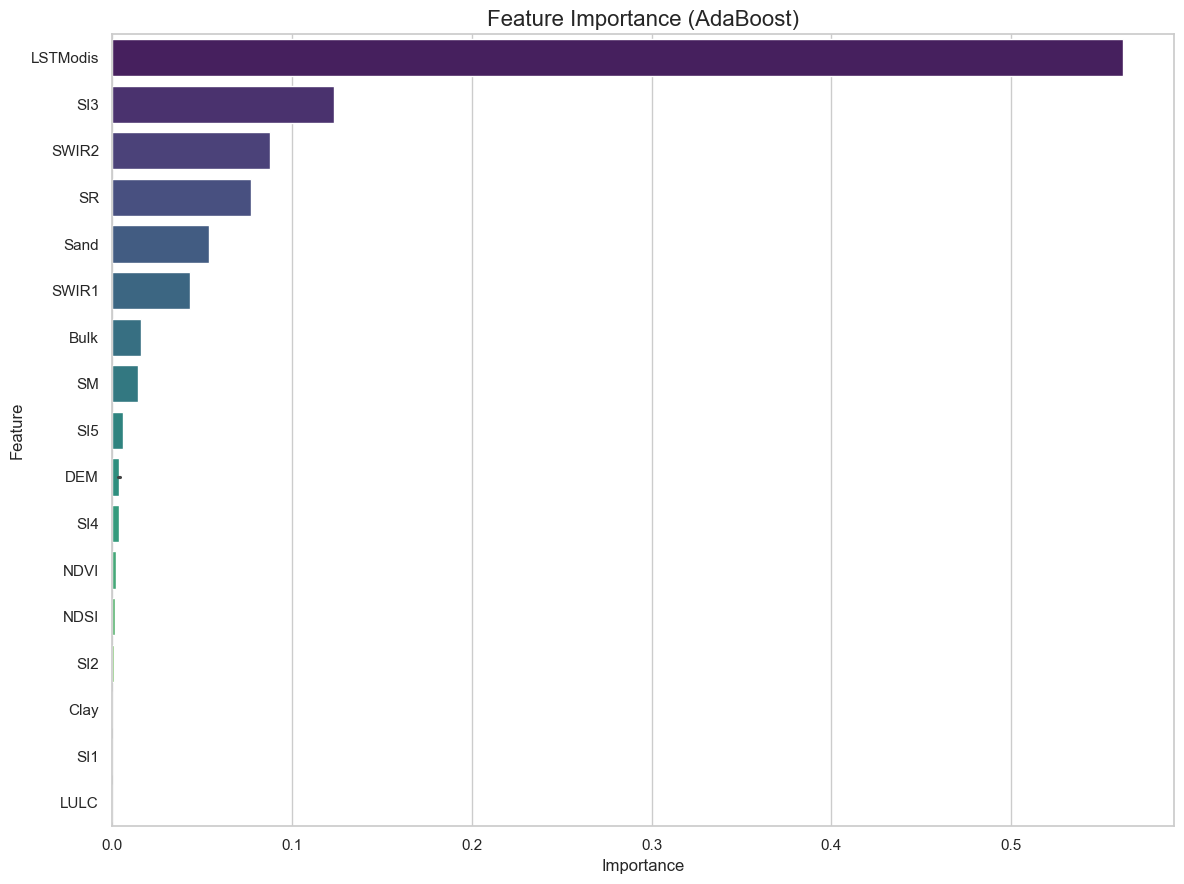

In [ ]:
# ---- Feature Importance ----
adaboost_model.fit(X, y)
importances = adaboost_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, len(features) * 0.5))
sns.barplot(
    x=importances[indices], 
    y=np.array(features)[indices], 
    palette="viridis", 
    orient="h"
)
plt.title("Feature Importance (AdaBoost)", fontsize=16)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

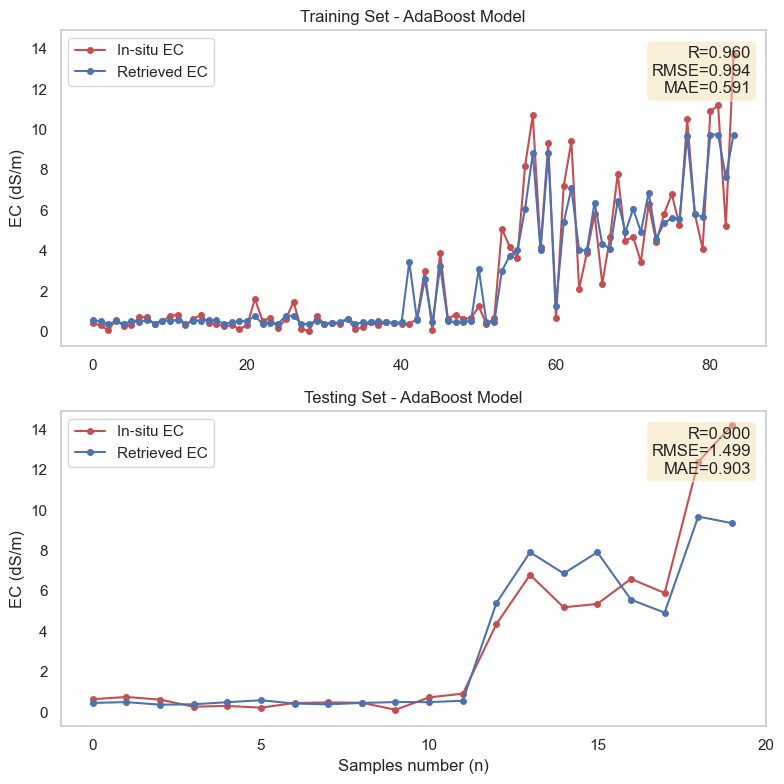

In [ ]:
# ---- Prediction Plots ----
fig, axes = plt.subplots(2, 1, figsize=(8,8), sharey=True)

axes[0].grid(False)
axes[1].grid(False)

# Training set
axes[0].plot(range(len(y_train)), y_train, 'r-o', label="In-situ EC", markersize=4)
axes[0].plot(range(len(y_train)), y_train_pred, 'b-o', label="Retrieved EC", markersize=4)
axes[0].set_title("Training Set - AdaBoost Model")
axes[0].set_ylabel("EC (dS/m)")
axes[0].legend()
axes[0].text(0.98, 0.95,
             f"R={np.mean(train_r2_scores):.3f}\nRMSE={np.mean(train_rmse_scores):.3f}\nMAE={np.mean(train_mae_scores):.3f}",
             transform=axes[0].transAxes, ha="right", va="top",
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Testing set
axes[1].plot(range(len(y_test)), y_test, 'r-o', label="In-situ EC", markersize=4)
axes[1].plot(range(len(y_test)), y_test_pred, 'b-o', label="Retrieved EC", markersize=4)
axes[1].set_title("Testing Set - AdaBoost Model")
axes[1].set_xlabel("Samples number (n)")
axes[1].set_ylabel("EC (dS/m)")
axes[1].legend()
axes[1].text(0.98, 0.95,
             f"R={np.mean(test_r2_scores):.3f}\nRMSE={np.mean(test_rmse_scores):.3f}\nMAE={np.mean(test_mae_scores):.3f}",
             transform=axes[1].transAxes, ha="right", va="top",
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1].set_xticks(np.arange(0, len(y_test)+1, 5))

plt.tight_layout()
plt.show()

In [ ]:
# ---- Load Raster Libraries ----
import rasterio
from rasterio.transform import Affine
from rasterio.crs import CRS
from rasterio.warp import reproject, Resampling
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path

In [ ]:
# ---- Load All Raster Data ----
data_folder = r'D:\Download\DA\DA\TV\TV2024_08\RASTER'

raster_files = {
    'Sand': 'Sand.tif',
    'Clay': 'Clay.tif', 
    'Bulk': 'Bulk.tif',
    'LSTModis': 'LST.tif',
    'SM': 'SM.tif',
    'SR': 'SR.tif',
    'NDSI': 'NDSI.tif',
    'NDVI': 'NDVI.tif',
    'DEM': 'DEM.tif',
    'LULC': 'LULC.tif',
    'SI1': 'SI1.tif',
    'SI2': 'SI2.tif',
    'SI3': 'SI3.tif',
    'SI4': 'SI4.tif',
    'SI5': 'SI5.tif',
    'SWIR1': 'SWIR1.tif',
    'SWIR2': 'SWIR2.tif',
}

raster_data = {}
print("Loading raster files...")
for var_name, filename in raster_files.items():
    filepath = os.path.join(data_folder, filename)
    if os.path.exists(filepath):
        with rasterio.open(filepath) as src:
            raster_data[var_name] = src.read(1)
        print(f"  ✓ {var_name}")
    else:
        print(f"  ✗ {var_name} - File not found")

with rasterio.open(os.path.join(data_folder, 'LST.tif')) as ref_src:
    reference_transform = ref_src.transform
    reference_crs = ref_src.crs
    reference_shape = ref_src.shape
    reference_bounds = ref_src.bounds

print(f"\nReference raster shape: {reference_shape}")
print(f"Reference CRS: {reference_crs}")

In [ ]:
# ---- Prepare Data for Prediction ----
min_rows = min([data.shape[0] for data in raster_data.values()])
min_cols = min([data.shape[1] for data in raster_data.values()])

prediction_features = []
for feature_name in features:
    raster_cropped = raster_data[feature_name][:min_rows, :min_cols]
    raster_flattened = raster_cropped.flatten()
    prediction_features.append(raster_flattened)

X_prediction = np.column_stack(prediction_features)
valid_mask = ~np.any((X_prediction == -9999) | np.isnan(X_prediction), axis=1)
reference_shape = (min_rows, min_cols)

print(f"Prediction array shape: {X_prediction.shape}")
print(f"Valid pixels: {np.sum(valid_mask)} / {len(valid_mask)} ({100*np.sum(valid_mask)/len(valid_mask):.2f}%)")

In [ ]:
# ---- Train Final AdaBoost Model ----
df_clean = pd.read_csv(CSV_PATH)
df_clean = df_clean.loc[~(df_clean[features] == -9999).any(axis=1)].copy()
df_clean = df_clean[~df_clean[target].isna()]

X_train_final = df_clean[features].values
y_train_final = df_clean[target].values

final_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(
        max_depth=best_params['estimator__max_depth'],
        min_samples_split=best_params['estimator__min_samples_split'],
        min_samples_leaf=best_params['estimator__min_samples_leaf'],
        random_state=random_state
    ),
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate'],
    loss='linear',
    random_state=random_state
)

print("Training final AdaBoost model on full dataset...")
final_model.fit(X_train_final, y_train_final)
print("✓ Training complete")

In [ ]:
# ---- Make Spatial Predictions ----
print("Making spatial predictions...")
predictions = np.full(len(X_prediction), np.nan)

if np.sum(valid_mask) > 0:
    X_valid = X_prediction[valid_mask]
    predictions_valid = final_model.predict(X_valid)
    predictions[valid_mask] = predictions_valid

prediction_raster = predictions.reshape(reference_shape)
print("✓ Predictions complete")

In [ ]:
# ---- Visualize Prediction Map ----
plt.figure(figsize=(12, 8))
im = plt.imshow(prediction_raster, cmap='RdYlBu_r', interpolation='nearest')
plt.colorbar(im, label='Predicted EC (dS/m)', shrink=0.7)
plt.title('Electrical Conductivity Prediction Map (AdaBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Column (pixels)')
plt.ylabel('Row (pixels)')
plt.tight_layout()
plt.show()

In [ ]:
# ---- Print Raster Statistics ----
valid_predictions_raster = prediction_raster[~np.isnan(prediction_raster)]
valid_predictions_raster = np.clip(valid_predictions_raster, 0, None)

if len(valid_predictions_raster) > 0:
    print("="*50)
    print("=== Prediction Raster Statistics ===")
    print("="*50)
    print(f"Min EC:    {np.min(valid_predictions_raster):.4f} dS/m")
    print(f"Max EC:    {np.max(valid_predictions_raster):.4f} dS/m")
    print(f"Mean EC:   {np.mean(valid_predictions_raster):.4f} dS/m")
    print(f"Median EC: {np.median(valid_predictions_raster):.4f} dS/m")
    print(f"Std EC:    {np.std(valid_predictions_raster):.4f} dS/m")
    print("="*50)

In [ ]:
# ---- Save Prediction Raster ----
prediction_raster = np.clip(prediction_raster, 0, None)

output_tif = r"D:\Download\DA\DA\TV\TV2024_08\Outputs\EC_Prediction_AdaBoost.tif"

# Create output folder if not exists
os.makedirs(os.path.dirname(output_tif), exist_ok=True)

with rasterio.open(
    output_tif,
    "w",
    driver="GTiff",
    height=prediction_raster.shape[0],
    width=prediction_raster.shape[1],
    count=1,
    dtype=prediction_raster.dtype,
    crs=reference_crs,
    transform=reference_transform,
    nodata=np.nan,
    compress='lzw'
) as dst:
    dst.write(prediction_raster, 1)

print(f"✓ Prediction raster saved to:")
print(f"  {output_tif}")